In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.textpath import TextPath
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('../dataset/complete_dataset.csv')
dfs = df.sample(frac=1)
dfs.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,1,3,5,6,7,8,9,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(10927181, 19)

In [3]:
#df.dropna(subset=['text', 'genre', 'year', 'production_region'], inplace=True)
df.drop_duplicates(subset=['IMDB_ID'], inplace=True)
df.shape

(6832110, 19)

# Clustering über Zeit mit Embeddings

In [4]:
from pathlib import Path
import numpy as np
def read_embeddings(embedding_file: str):
    data = Path(embedding_file).read_text()
    lines = data.split('\n')
    filenames = []
    embeddings = []
    for line in lines:
        line_data = line.split(' ')
        if len(line_data) >=2 :
            filenames.append(line_data[0])
            embeddings.append(list(map(float, line_data[1:])))
    return np.asarray(filenames), np.asarray(embeddings)

In [6]:
filenames, embeddings = read_embeddings('../dataset/embeddings_mean.txt')

In [7]:
filenames.shape, embeddings.shape

((34473,), (34473, 300))

In [11]:
df = df[df['filename'].isin(filenames)].copy()
df.shape

(34473, 20)

In [9]:
(df.filename == filenames).all()

True

In [12]:
#Einfügen der Embeddings ins Dataframe
df['embedding'] = [e for e in embeddings]
df.shape

(34473, 20)

## Plot über Zeit

Mean:  2000.6876090243052 Median:  2008.0


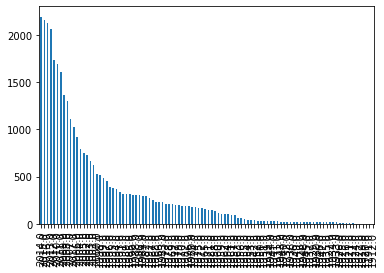

In [13]:
pd.value_counts(df['year']).plot.bar()
print('Mean: ', df['year'].mean(), 'Median: ', df['year'].median())

## Split der Daten in Zeitperioden

In [15]:
sincevalue = 2017
beforevalue = 2000
since = df.year >= sincevalue
before = df.year <= beforevalue
years = since + before
years.shape
colorlist = []

for x in df.year:
    if x >=2017:
        colorlist.append('red')
    elif x <= 2007:
        colorlist.append('blue')
    else: 
        colorlist.append('white')

In [16]:
df['labelcolor']=colorlist

## K-Means

In [17]:
model = KMeans(n_clusters=2)
model.fit(embeddings)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
len(model.labels_)

34473

## PCA

In [21]:
pca = PCA(n_components=2)
pca.fit(embeddings)
X_tf = pca.transform(embeddings)

#Abspeichern der Zwischenergebnisste im Datafram
df['pca2d_1'] = X_tf[:,0]
df['pca2d_2'] = X_tf[:,1]
df['kmeans'] = model.labels_




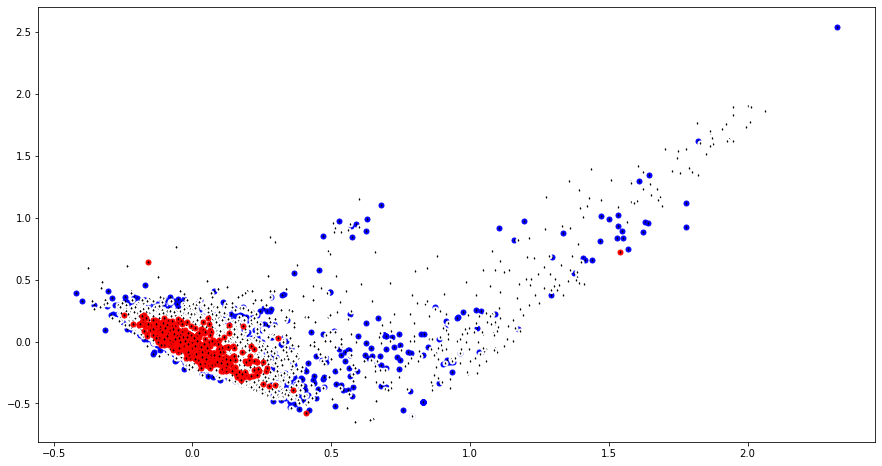

In [28]:
#Plotten anhand der gespeicherten Zwischenergebnisse 
plt.figure(figsize=(15,8))
for d in df.iterrows():
    x = d[1].pca2d_1
    y = d[1].pca2d_2    
    plt.plot(x, y, 'o', markersize=5, color= d[1].labelcolor)
    plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].kmeans}'), color='black', markersize=1)

34473


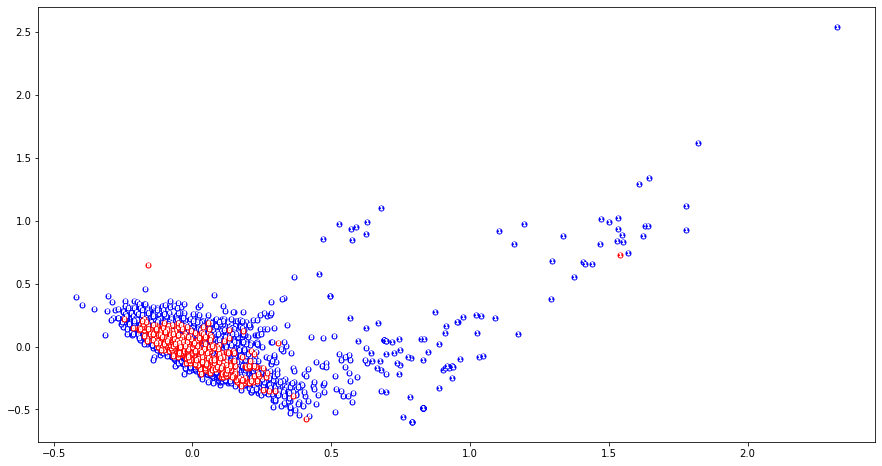

In [32]:
pca = PCA(n_components=2)
pca.fit(embeddings)
X_tf = pca.transform(embeddings)
print(len(X_tf))
df['pca2d_1'] = X_tf[:,0]
df['pca2d_2'] = X_tf[:,1]
df['kmeans'] = model.labels_

df_clean = df[df.labelcolor != 'white']
#df_embedding = df_clean['embedding']
#df_embedding.tolist()

plt.figure(figsize=(15,8))
for d in df_clean.iterrows():
    x = d[1].pca2d_1
    y = d[1].pca2d_2    
    plt.plot(x, y, 'o', markersize=5, color= d[1].labelcolor)
    plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].kmeans}'), color='white', markersize=4)


### Verteilung der Ergebnisse

In [33]:
b1 = df.loc[(df['kmeans'] == 1) & (df['labelcolor'] == 'blue')]
b0 = df.loc[(df['kmeans'] == 0) & (df['labelcolor'] == 'blue')]
r1 = df.loc[(df['kmeans'] == 1) & (df['labelcolor'] == 'red')]
r0 = df.loc[(df['kmeans'] == 0) & (df['labelcolor'] == 'red')]
print('b1: ', len(b1), 'b0: ', len(b0), 'r1: ', len(r1), 'r0: ', len(r0))

b1:  121 b0:  16985 r1:  1 r0:  1022


# Ohne Embeddings

(61309, 22)

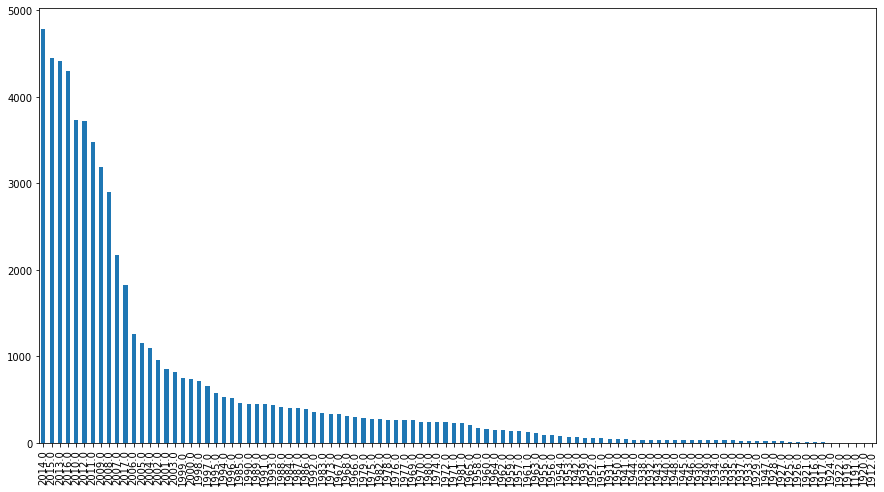

In [34]:
dfs.dropna(subset=['text', 'year'], inplace=True)
plt.figure(figsize=(15,8))
pd.value_counts(dfs['year']).plot.bar()
dfs.shape

## Split in Zeitperioden

white    53379
red       4294
blue      3636
Name: colors, dtype: int64

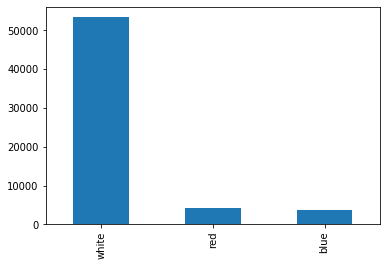

In [35]:
#Aufteilung in 1950 bis 1970 und 2016
colors = []
for x in dfs.year:
    if x == 2016:
        colors.append('red')
    elif (x <= 1970) & (x >= 1940):
        colors.append('blue')
    else: 
        colors.append('white')
dfs['colors']=colors
      
pd.value_counts(dfs.colors).plot.bar() 
pd.value_counts(dfs.colors)

# K-Means

In [36]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
tokens = tfidf.fit_transform(dfs.text)
#vectorizer = CountVectorizer()
#X = vectorizer.fit_transform(df_split.text)

In [37]:
tokens.toarray(), tokens.shape

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.01104983,
         0.        ],
        [0.00920931, 0.00591213, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.01489421, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.01227138,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 (61309, 10000))

In [ ]:
models = KMeans(n_clusters=2)
models.fit(tokens)

In [ ]:
len(models.labels_)

In [ ]:
pca = PCA(n_components=2)
pca.fit(tokens.todense())
X_tf = pca.transform(tokens.todense())

#Abspeichern der Zwischenergebnisste im Datafram
dfs['pcatokens_1'] = X_tf[:,0]
dfs['pcatokens_2'] = X_tf[:,1]
dfs['kmeanstokens'] = models.labels_

dfs_clean = dfs[dfs.colors != 'white']

#Plotten anhand der gespeicherten Zwischenergebnisse 
plt.figure(figsize=(15,8))
for d in dfs_clean.iterrows():
    x = d[1].pcatokens_1
    y = d[1].pcatokens_2    
    plt.plot(x, y, 'o', markersize=4, color= d[1].colors)
    plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].kmeanstokens}'), color='black', markersize=1)
